In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast

import matplotlib.pyplot as plt

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = './data/'
sampling_rate=100
#sampling_rate = 500

In [3]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [4]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [5]:
# Load raw signal data
%time X = load_raw_data(Y, sampling_rate, path)

Wall time: 4min 42s


In [6]:
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

In [7]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


In [8]:
agg_df.index

Index(['NDT', 'NST_', 'DIG', 'LNGQT', 'NORM', 'IMI', 'ASMI', 'LVH', 'LAFB',
       'ISC_', 'IRBBB', '1AVB', 'IVCD', 'ISCAL', 'CRBBB', 'CLBBB', 'ILMI',
       'LAO/LAE', 'AMI', 'ALMI', 'ISCIN', 'INJAS', 'LMI', 'ISCIL', 'LPFB',
       'ISCAS', 'INJAL', 'ISCLA', 'RVH', 'ANEUR', 'RAO/RAE', 'EL', 'WPW',
       'ILBBB', 'IPLMI', 'ISCAN', 'IPMI', 'SEHYP', 'INJIN', 'INJLA', 'PMI',
       '3AVB', 'INJIL', '2AVB'],
      dtype='object')

## data 확인

In [9]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [10]:
from collections import Counter

Counter([item for sublist in Y['diagnostic_superclass'] for item in sublist])

Counter({'NORM': 9528, 'MI': 5486, 'STTC': 5250, 'HYP': 2655, 'CD': 4907})

In [11]:
len(Y[['height', 'weight']].dropna())    

6756

In [12]:
Y[['height', 'weight']].dropna()

,height,weight
ecg_id,,
101,172.0,72.0
116,174.0,74.0
136,167.0,72.0
139,181.0,69.0
140,164.0,54.0
...,...,...
20943,174.0,80.0
20970,168.0,74.0
21040,168.0,74.0


In [13]:
X.shape, type(X)

((21837, 1000, 12), numpy.ndarray)

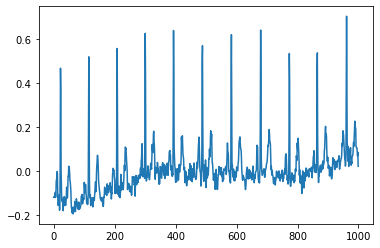

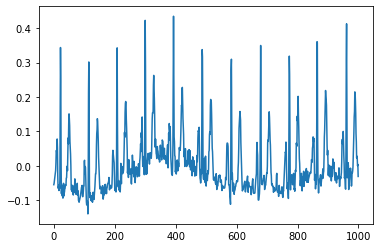

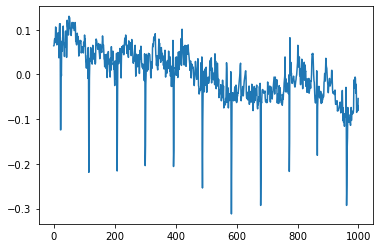

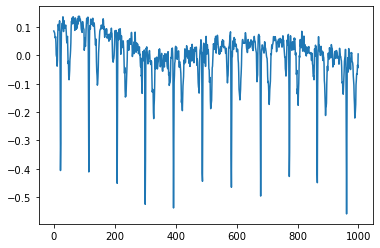

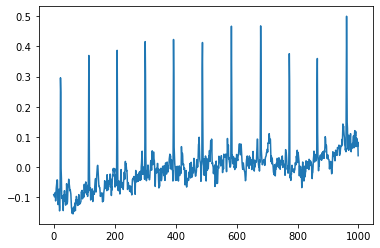

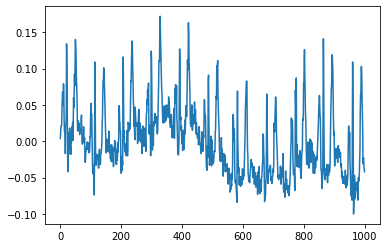

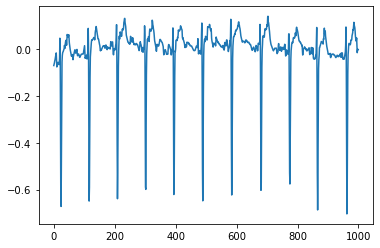

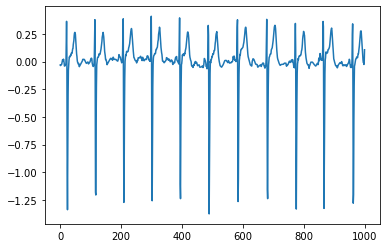

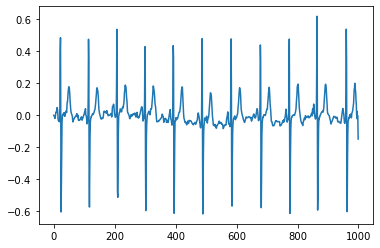

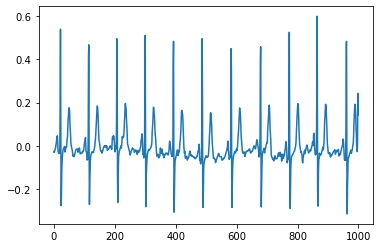

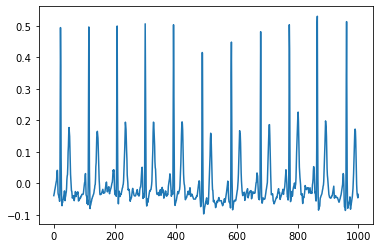

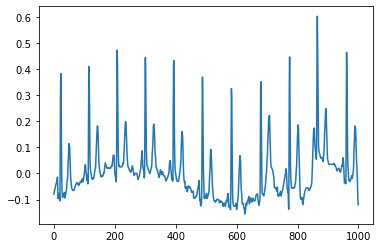

In [14]:
for i in range(12):
    plt.plot(X[0, :, i])
    plt.show()

# Get Data (X, Y_subject)

In [15]:
Y_subject = Y.dropna(subset = ["weight", 'height'], inplace=False)
# Y_subject = Y_subject.loc[Y_subject['diagnostic_superclass'].apply(str) == str(['NORM'])]

In [16]:
Y_subject

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
101,9086.0,48.0,1,172.0,72.0,0.0,0.0,CS-12 E,1985-12-11 11:50:40,sinusrytm normalt ekg,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/00000/00101_lr,records500/00000/00101_hr,[NORM]
116,19695.0,49.0,1,174.0,74.0,2.0,0.0,CS-12 E,1986-01-10 14:00:09,sinusrhythmus linkstyp unspezifisches abnormal...,...,NaN,", I,III-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00116_lr,records500/00000/00116_hr,[STTC]
136,13445.0,52.0,0,167.0,72.0,NaN,3.0,CS-12 E,1986-02-21 16:49:02,sinusrytm normalt ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00136_lr,records500/00000/00136_hr,[NORM]
139,11121.0,58.0,0,181.0,69.0,NaN,3.0,CS-12 E,1986-02-23 08:05:45,sinusrytm ospecifikt inkomplett skÄnkelblock a...,...,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00139_lr,records500/00000/00139_hr,[MI]
140,13451.0,27.0,1,164.0,54.0,NaN,3.0,CS-12 E,1986-02-23 08:06:51,sinusrytm vÄnster kammarhypertrofi,...,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00140_lr,records500/00000/00140_hr,"[HYP, STTC]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20943,8542.0,52.0,0,174.0,80.0,1.0,2.0,CS-12,1999-12-18 17:15:19,sinusrhythmus lagetyp normal unspezifische abn...,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/20000/20943_lr,records500/20000/20943_hr,[NORM]
20970,18531.0,58.0,0,168.0,74.0,1.0,2.0,AT-60 3,2000-01-04 09:17:10,sinustachykardie p-sinistrocardiale linkstyp p...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/20000/20970_lr,records500/20000/20970_hr,"[STTC, MI]"
21040,18531.0,58.0,0,168.0,74.0,1.0,2.0,AT-60 3,2000-01-22 09:04:39,sinusrhythmus a-v block i p-sinistrocardiale l...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/21000/21040_lr,records500/21000/21040_hr,"[CD, STTC, MI]"


In [17]:
id_list = list(Y_subject.index)
id_list = [x-1 for x in id_list]

In [18]:
X = X[id_list, :, :]

In [19]:
X.shape

(6756, 1000, 12)

In [20]:
Y_subject['bmi'] = Y_subject['weight']*(10**4)/(Y_subject['height']**2)

C:\Users\qw070\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
Y_subject

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,bmi
ecg_id,,,,,,,,,,,,,,,,,,,,,
101,9086.0,48.0,1,172.0,72.0,0.0,0.0,CS-12 E,1985-12-11 11:50:40,sinusrytm normalt ekg,...,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/00000/00101_lr,records500/00000/00101_hr,[NORM],24.337480
116,19695.0,49.0,1,174.0,74.0,2.0,0.0,CS-12 E,1986-01-10 14:00:09,sinusrhythmus linkstyp unspezifisches abnormal...,...,", I,III-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00116_lr,records500/00000/00116_hr,[STTC],24.441802
136,13445.0,52.0,0,167.0,72.0,NaN,3.0,CS-12 E,1986-02-21 16:49:02,sinusrytm normalt ekg,...,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00136_lr,records500/00000/00136_hr,[NORM],25.816630
139,11121.0,58.0,0,181.0,69.0,NaN,3.0,CS-12 E,1986-02-23 08:05:45,sinusrytm ospecifikt inkomplett skÄnkelblock a...,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00139_lr,records500/00000/00139_hr,[MI],21.061628
140,13451.0,27.0,1,164.0,54.0,NaN,3.0,CS-12 E,1986-02-23 08:06:51,sinusrytm vÄnster kammarhypertrofi,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00140_lr,records500/00000/00140_hr,"[HYP, STTC]",20.077335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20943,8542.0,52.0,0,174.0,80.0,1.0,2.0,CS-12,1999-12-18 17:15:19,sinusrhythmus lagetyp normal unspezifische abn...,...,NaN,NaN,NaN,NaN,NaN,10,records100/20000/20943_lr,records500/20000/20943_hr,[NORM],26.423570
20970,18531.0,58.0,0,168.0,74.0,1.0,2.0,AT-60 3,2000-01-04 09:17:10,sinustachykardie p-sinistrocardiale linkstyp p...,...,NaN,NaN,NaN,NaN,NaN,6,records100/20000/20970_lr,records500/20000/20970_hr,"[STTC, MI]",26.218821
21040,18531.0,58.0,0,168.0,74.0,1.0,2.0,AT-60 3,2000-01-22 09:04:39,sinusrhythmus a-v block i p-sinistrocardiale l...,...,NaN,NaN,NaN,NaN,NaN,6,records100/21000/21040_lr,records500/21000/21040_hr,"[CD, STTC, MI]",26.218821


In [22]:
np.save('./X_all_diag.npy', X) 
Y_subject.to_csv('./Y_subject_all_diag.csv', index=False)